## Introduction
### Problem Statement:-

Brain tumors are abnormal growths of tissue in the brain and can be life-threatening if not diagnosed early. In medical imaging, segmenting tumors from MRI scans helps radiologists identify and localize these tumors accurately.

### solution:-

This notebook tackles the task of semantic segmentation that classifying each pixel in an MRI image as tumor or nontumor using the U-Net architecture, which is well-suited for biomedical image segmentation.

### Dataset Overview:-

Dataset link:-https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation/data

->Images – MRI scans of brain (3024 images-gray scale values)

->Masks – Binary masks where tumor regions are marked in white (pixel value 1), and non-tumor regions are black (pixel value 0)

->Each image and mask pair has the same filename, making it easy to match them for supervised learning.

### Goals of This Notebook:-

->Preprocess the images and masks

->Build a U-Net model from scratch using TensorFlow

->Train and evaluate the model using Dice Coefficient and Loss

->Visualize predictions and interpret segmentation results



## Import libraries


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import normalize
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping 
#learning rate scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau


E0000 00:00:1750075218.712309      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750075218.770693      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data preprocessing

Add this data set before run the below command:-

https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation


In [2]:
image_dir = "/kaggle/input/brain-tumor-segmentation/images"
mask_dir = "/kaggle/input/brain-tumor-segmentation/masks"

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

print("Number of images:", len(image_files))
print("Number of masks:", len(mask_files))

Number of images: 3064
Number of masks: 3064


In [3]:
# Fixed image size
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Initialize lists to store image and mask data
images = []
masks = []


In [4]:
for img_name, mask_name in zip(image_files, mask_files):
    # Read image and mask in grayscale
    img = cv2.imread(os.path.join(image_dir, img_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)

    # Resize both to 512x512 which is input to the unet
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))

    # Append to lists
    images.append(img)
    masks.append(mask)


In [5]:
# Convert to NumPy arrays
images = np.array(images)
masks = np.array(masks)

In [6]:
# Normalize images to range [0, 1]
images = images / 255.0
# Normalize to [0, 1] and binarize
masks = masks / 255.0
masks = (masks > 0.5).astype(np.float32)


### sample image and mask

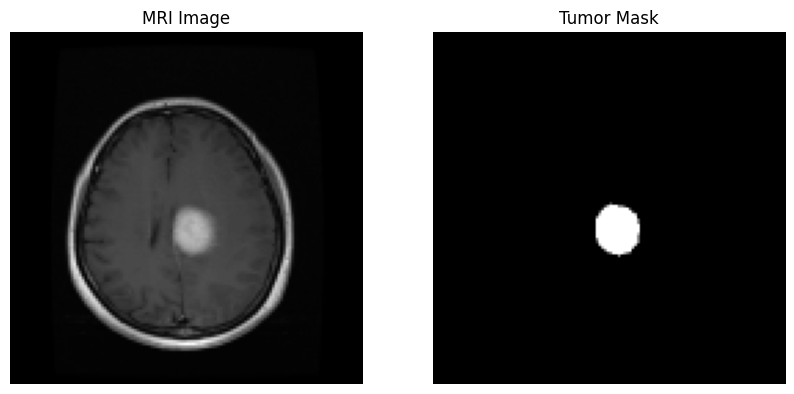

In [7]:
# Load the first image and its mask in grayscale
sample_img = images[1]
sample_mask = masks[1]

# Resize both to 128x128 for quick visualizationx
sample_img = cv2.resize(sample_img, (128, 128))
sample_mask = cv2.resize(sample_mask, (128, 128))

# Plot side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("MRI Image")
plt.imshow(sample_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Tumor Mask")
plt.imshow(sample_mask, cmap='gray')
plt.axis('off')

plt.show()

In [8]:
# Reshape to add channel dimension (needed for U-Net input)
images = images.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
masks = masks.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

print("Image shape:", images.shape)
print("Mask shape:", masks.shape)

Image shape: (3064, 256, 256, 1)
Mask shape: (3064, 256, 256, 1)


### train_test_split

In [9]:
# Step 1: Split into train and temp (temp will be split into val and test)
x_train, x_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)

# Step 2: Split temp into val and test
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.33, random_state=42)

print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_val.shape, y_val.shape)
print("Test: ", x_test.shape, y_test.shape)


Train: (2144, 256, 256, 1) (2144, 256, 256, 1)
Val:   (616, 256, 256, 1) (616, 256, 256, 1)
Test:  (304, 256, 256, 1) (304, 256, 256, 1)


## Define U-Net Model

In [24]:
tf.keras.backend.clear_session()

In [10]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c6)

    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32 ,(3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

## Define Dice Coefficient and Loss

In [11]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [12]:
model = unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 1))
model.compile(optimizer=Adam(learning_rate=0.0001), loss=dice_loss, metrics=[dice_coef])
model.summary()

I0000 00:00:1750075403.806288      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 8,934,417 (34.08 MB)

 Trainable params: 8,934,417 (34.08 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [14]:
history = model.fit(x_train,y_train,
                    validation_data=(x_val, y_val),
                    epochs=100,
                    )

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 256, 256, 1))
  warnings.warn(msg)
I0000 00:00:1750075433.450659      99 service.cc:148] XLA service 0x796cb0025560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750075433.451327      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750075434.429246      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750075468.676368      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - dice_coef: 0.0481 - loss: 0.9519

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


67/67 ━━━━━━━━━━━━━━━━━━━━ 77s 485ms/step - dice_coef: 0.0485 - loss: 0.9515 - val_dice_coef: 0.0874 - val_loss: 0.9125
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 265ms/step - dice_coef: 0.1192 - loss: 0.8808 - val_dice_coef: 0.1110 - val_loss: 0.8885
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 266ms/step - dice_coef: 0.1430 - loss: 0.8570 - val_dice_coef: 0.1234 - val_loss: 0.8759
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - dice_coef: 0.1428 - loss: 0.8572 - val_dice_coef: 0.1307 - val_loss: 0.8682
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - dice_coef: 0.2054 - loss: 0.7946 - val_dice_coef: 0.2683 - val_loss: 0.7289
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - dice_coef: 0.3206 - loss: 0.6794 - val_dice_coef: 0.2931 - val_loss: 0.7037
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - dice_coef: 0.3667 - loss: 0.6333 - val_dice_coef: 0.3377 - val_loss: 0.6605
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - dice_coef: 0.3929 - loss: 0.6071

## Testing

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 744ms/step


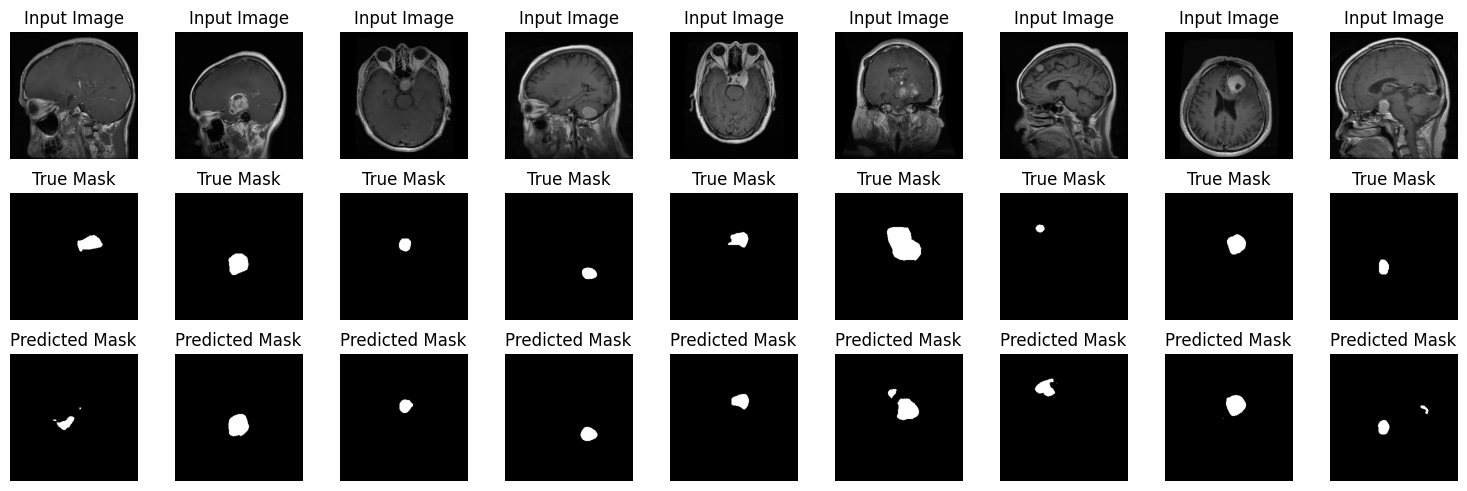

In [15]:
import matplotlib.pyplot as plt


# Predict on test images
preds = model.predict(x_test)

# Binarize predictions
preds = (preds > 0.5).astype(np.float32)

# Show some results
n = 9  # number of samples to display
plt.figure(figsize=(15, 5))
for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(3, n, i + 1 + n)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


## plotting Dice coefficient and loss

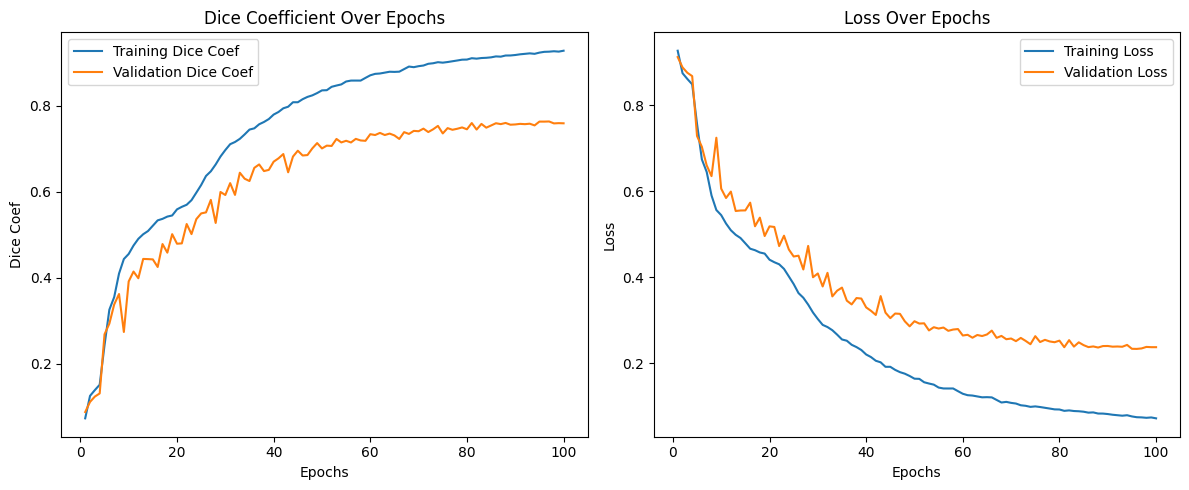

In [16]:
import matplotlib.pyplot as plt

# Extract metrics
dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot
epochs = range(1, len(dice) + 1)

plt.figure(figsize=(12, 5))

# Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(epochs, dice, label='Training Dice Coef')
plt.plot(epochs, val_dice, label='Validation Dice Coef')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Prediction for a Specific Input

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


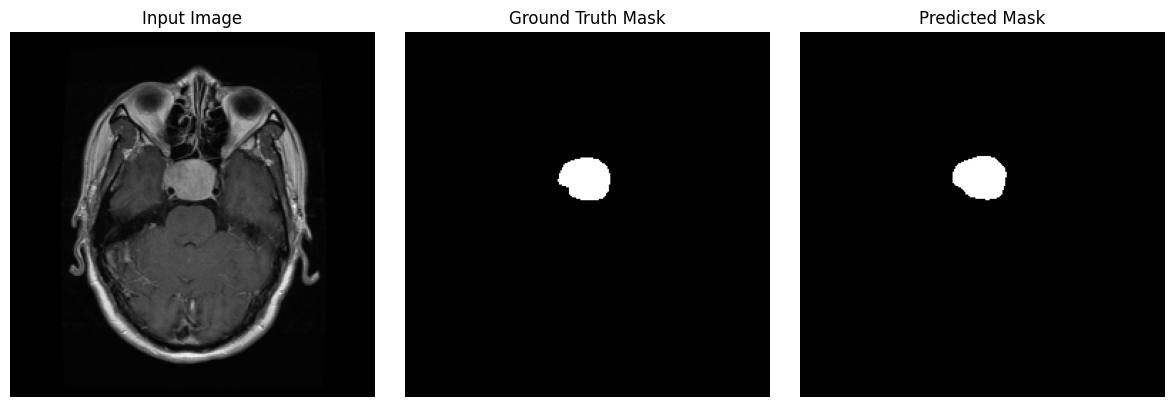

In [17]:
i = 300  # any valid index from test set

# Get input image, true mask, predicted mask
image = x_test[i]
true_mask = y_test[i]
pred_mask = model.predict(np.expand_dims(image, axis=0))[0]

# Binarize the prediction
pred_mask = (pred_mask > 0.5).astype(np.float32)

# Plot all three
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()
